In [1]:
# 2) clone Tuan's resyslab (always required whenever starting a session in kaggle)
import os
if not os.path.exists('/kaggle/working/resyslab_utils'):
    !git clone https://github.com/Azure2212/resyslab_utils.git
%run /kaggle/working/resyslab_utils/resyslab_utils/clouds/cloud_setup.py

Cloning into 'resyslab_utils'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 151 (delta 55), reused 130 (delta 38), pack-reused 0 (from 0)
Receiving objects: 100% (151/151), 30.63 KiB | 3.83 MiB/s, done.
Resolving deltas: 100% (55/55), done.
---------------Tuan's resyslab library started!---------------


In [2]:
# 3) set authority right to push to github by using ssh
setup_github_config(private_key_path = '/kaggle/input/bayesnetworkcl/cogload_BN')

> Setup ssh github...
Key name: cogload_BN
Copy: /kaggle/input/bayesnetworkcl/cogload_BN --> ~/.ssh/cogload_BN
setup github_config finished


In [3]:
# 4) pull code from github into kaggle using ssh private key setted up in previous step
clone_project_from_github(giturl = 'git@github.com:TyTy7023/CogLoad_BayesNetwork.git',
                          folder = '/kaggle/working/cogload', branch = 'getPDT')

Cloning into '/kaggle/working/cogload'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 1100 (delta 53), reused 25 (delta 8), pack-reused 980 (from 1)
Receiving objects: 100% (1100/1100), 7.44 MiB | 9.06 MiB/s, done.
Resolving deltas: 100% (611/611), done.


In [4]:
cd /kaggle/working/cogload

/kaggle/working/cogload


# Run model

%run -i /kaggle/working/cogload/Test/test_drawDAG.py --GroupKFold 5

In [59]:
import sys
import pandas as pd
import numpy as np

sys.path.append('/kaggle/working/cogload/')
from install_library import install_and_import
install_and_import('pgmpy')

sys.path.append('/kaggle/working/cogload/Exploratory_Data')
from EDA import EDA

from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from sklearn.metrics import accuracy_score

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ExpectationMaximization
from pgmpy.inference import VariableElimination
from sklearn.model_selection import GroupKFold

class BN:
    def __init__(self, data, method='hill_climbing'):
        self.data = data
        self.target = 'Labels'
        self.method = method
        if method not in ['hill_climbing', 'tabu_search']:
            raise ValueError('Method not found')
        self.edges = self.Hill_climbing(data) if method == 'hill_climbing' else self.tabu_search(data)

    def Hill_climbing(self, data):
        hc = HillClimbSearch(data)
        hill_dag = hc.estimate(scoring_method=BicScore(data))
        return hill_dag.edges()
    
    def tabu_search(self, data, max_iter=100, tabu_length=10):
        tabu_list = []
        hc = HillClimbSearch(data)

        # Khởi tạo mô hình
        best_model = hc.estimate(scoring_method=BicScore(data))
        best_score = BicScore(data).score(best_model)

        for _ in range(max_iter):
            # Biến đổi mô hình hiện tại
            candidate = mutate_graph(best_model.copy())
            
            if any(set(candidate.edges) == set(tabu.edges) for tabu in tabu_list):
                continue  # Bỏ qua nếu đồ thị này đã trong danh sách Tabu

            score = BicScore(data).score(candidate)
            if score > best_score:  # Nếu mô hình mới tốt hơn, cập nhật
                best_model = candidate
                best_score = score

            # Thêm vào danh sách Tabu
            tabu_list.append(candidate)
            if len(tabu_list) > tabu_length:
                tabu_list.pop(0)  # Giữ danh sách Tabu có kích thước giới hạn

        return best_model.edges()

    def fit(self, X_train, y_train, user_train, splits):
        accuracies = []
        y_true_list = []
        y_prob_list = []
        
        print("Edges of DAG:", self.edges)
        edges = list(self.edges)
        model = BayesianNetwork(edges)
        best_acc = 0
        self.best_model = None
    
        kf = GroupKFold(n_splits=splits)
    
        for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups=user_train)):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
            
            train_val_data = pd.concat([X_train_fold.reset_index(drop=True), 
                                    y_train_fold.reset_index(drop=True)], axis=1)
            test_val_data = pd.concat([X_val_fold.reset_index(drop=True), 
                                    y_val_fold.reset_index(drop=True)], axis=1)
            
            unique_nodes = set(node for edge in self.edges for node in edge)
            print('len unique nodes: ',len(unique_nodes))
            
            self.cols_drop = []
            columns = train_val_data.columns
            for col in columns:
                if col not in list(unique_nodes):
                    self.cols_drop.append(col)
            train_val_data = train_val_data.drop(columns = self.cols_drop)
            test_val_data = test_val_data.drop(columns = self.cols_drop)
            print('Shape train test val: ',train_val_data.shape,test_val_data.shape)
            
            # Huấn luyện mô hình
            model.fit(train_val_data, estimator=ExpectationMaximization)
    
            # Dự đoán trên tập test
            infer = VariableElimination(model)
            y_pred = []
            y_probs = []
    
            for _, row in test_val_data.iterrows():
                evidence = row.drop(self.target, errors='ignore').to_dict()
                q = infer.query(variables=[self.target], evidence=evidence)
                
                y_pred.append(q.values.argmax())  # Nhãn dự đoán
                y_probs.append(q.values[1])  # Xác suất của class 1
    
            acc = accuracy_score(test_val_data[self.target], y_pred)
            if acc > best_acc:
                best_acc = acc
                self.best_model = model
    
            accuracies.append(acc)
            y_true_list.append(test_val_data[self.target])
            y_prob_list.append(y_probs)

        path_EDA = '/kaggle/working/'
        EDA.draw_Bar(path_EDA, [f"fold {i+1}" for i in range(len(accuracies))] , accuracies, 'Accuracy Val')
        self.plot_roc(y_true_list, y_prob_list, 'ROC_val.png')
    
    def plot_roc(self, y_true_list, y_prob_list, name):
        plt.figure(figsize=(8, 6))
    
        for i, (y_true, y_prob) in enumerate(zip(y_true_list, y_prob_list)):
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
    
        plt.plot([0, 1], [0, 1], 'k--')  # Đường chéo
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Each Fold')
        plt.savefig(f"/kaggle/working/{name}", dpi=300, bbox_inches="tight")  # Lưu với độ phân giải cao
        plt.legend()
        plt.show()

    def get_PDT(self):
        '''
        Lấy bảng phân phối xác suất có điều kiện (CPD) của Bayesian Network
        '''
        if self.best_model is None:
            raise ValueError("Mô hình chưa được huấn luyện. Vui lòng chạy fit() trước.")
        
        pdt = {}
        for node in self.best_model.nodes():
            cpd = self.best_model.get_cpds(node)
            pdt[node] = cpd if cpd else "No CPD found"
        
        return pdt


    def predict(self, X_test, y_test):
        '''
        Predict with Bayesian Network
        '''
        infer = VariableElimination(self.best_model)
        y_pred = []
        test_set = pd.concat([X_test.reset_index(drop=True),y_test.reset_index(drop=True)], axis=1)
        test_set = test_set.drop(columns = self.cols_drop)

        y_probs = []
        for _, row in test_set.iterrows():
            evidence = row.drop(self.target, errors='ignore').to_dict()
            q = infer.query(variables=[self.target], evidence=evidence)
            
            y_pred.append(q.values.argmax())  # Nhãn dự đoán
            y_probs.append(q.values[1])  # Xác suất của class 1

        EDA.draw_ROC('/kaggle/working/',test_set[self.target], [y_probs],['BN_model'])
        # Tính Accuracy
        acc = accuracy_score(test_set[self.target], y_pred)
        return acc
    


Data shapes:
Labels (825, 21)
Data (825, 22)
Data shapes:
X_train (632, 21)
y_train (632, 1)
X_test (193, 21)
y_test (193, 1)


  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges of DAG: [('rr_diff2', 'HRV_RMSSD'), ('HRV_RMSSD', 'HRV_CVNN'), ('HRV_RMSSD', 'HRV_IALS'), ('HRV_CVNN', 'Labels'), ('HRV_CVNN', 'HRV_CSI_Modified'), ('HRV_CSI_Modified', 'HRV_MedianNN'), ('HRV_CSI_Modified', 'HRV_IALS'), ('HRV_IALS', 'HRV_PAS'), ('HRV_IALS', 'HRV_HFn')]
len unique nodes:  9
Shape train test val:  (504, 9) (128, 9)


  0%|          | 0/100 [00:00<?, ?it/s]

len unique nodes:  9
Shape train test val:  (517, 9) (115, 9)


  0%|          | 0/100 [00:00<?, ?it/s]

len unique nodes:  9
Shape train test val:  (518, 9) (114, 9)


  0%|          | 0/100 [00:00<?, ?it/s]

len unique nodes:  9
Shape train test val:  (500, 9) (132, 9)


  0%|          | 0/100 [00:00<?, ?it/s]

len unique nodes:  9
Shape train test val:  (489, 9) (143, 9)


  0%|          | 0/100 [00:00<?, ?it/s]

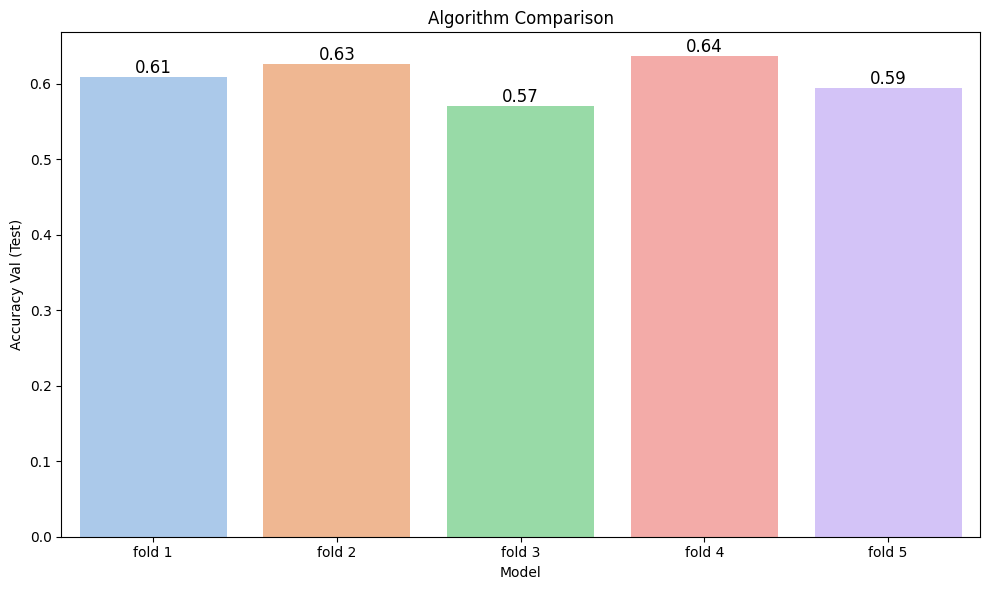

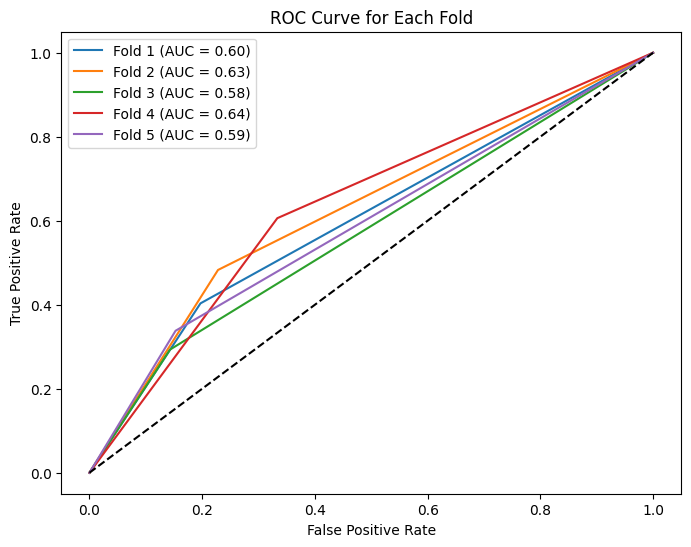

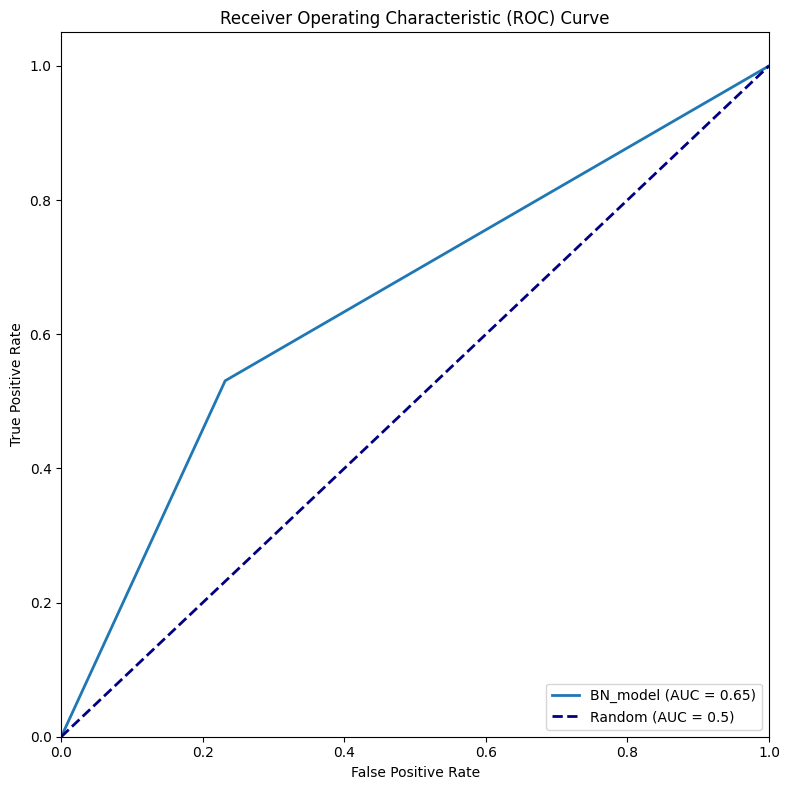

Accuracy: 0.6476683937823834
CPD của rr_diff2:
+-------------+----------+
| rr_diff2(0) | 0.331288 |
+-------------+----------+
| rr_diff2(1) | 0.668712 |
+-------------+----------+

CPD của HRV_RMSSD:
+--------------+---------------------+---------------------+
| rr_diff2     | rr_diff2(0)         | rr_diff2(1)         |
+--------------+---------------------+---------------------+
| HRV_RMSSD(0) | 0.25308641975308643 | 0.40061162079510704 |
+--------------+---------------------+---------------------+
| HRV_RMSSD(1) | 0.7469135802469136  | 0.599388379204893   |
+--------------+---------------------+---------------------+

CPD của HRV_CVNN:
+-------------+---------------------+---------------------+
| HRV_RMSSD   | HRV_RMSSD(0)        | HRV_RMSSD(1)        |
+-------------+---------------------+---------------------+
| HRV_CVNN(0) | 0.8197674418604651  | 0.07886435331230283 |
+-------------+---------------------+---------------------+
| HRV_CVNN(1) | 0.18023255813953487 | 0.921135646687

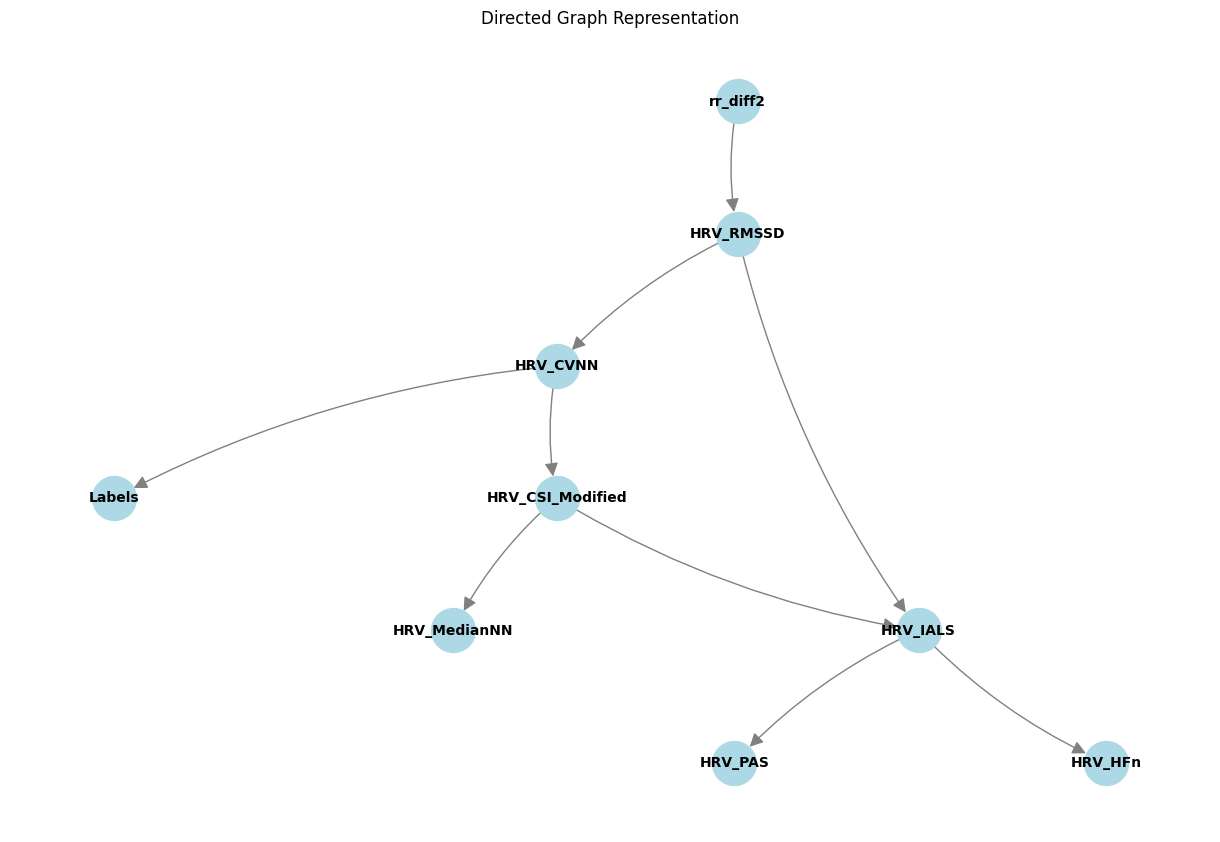

In [60]:
#to access files and folders
import os
#data analysis and manipulation library
import pandas as pd

import warnings
warnings.simplefilter("ignore")#ignore warnings during executiona

import sys
sys.path.append('/kaggle/working/cogload/BN_CognitiveLoad/')
from ProcessingData import Processing

data_labels_path = "/kaggle/input/cognitiveload/UBIcomp2020/last_30s_segments/"
data_path = "/kaggle/input/cognitiveload/Feature_selection/"

directory_name = '/kaggle/working/log/'
directory_result = '/kaggle/working/result/'
if not os.path.exists(directory_name):
    os.makedirs(directory_result)
    os.makedirs(directory_name)

#read the data
label_df = pd.read_excel(data_labels_path + 'labels.xlsx',index_col=0)
data = pd.read_csv(data_path + 'discrete_data.csv')
print("Data shapes:")
print('Labels',label_df.shape)
print('Data',data.shape)

#Processing data
process = Processing(data, label_df)
X_train, y_train, X_test, y_test, user_train, user_test = process.get_Data()
print("Data shapes:")
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)


# Draw DAG
bn = BN(data, method='hill_climbing')
bn.edges = [
    ("rr_diff2", "HRV_RMSSD"),
    ("HRV_RMSSD", "HRV_CVNN"),
    ("HRV_RMSSD", "HRV_IALS"),
    ("HRV_CVNN", "Labels"),
    ("HRV_CVNN", "HRV_CSI_Modified"),
    ("HRV_CSI_Modified", "HRV_MedianNN"),
    ("HRV_CSI_Modified", "HRV_IALS"),
    ("HRV_IALS", "HRV_PAS"),
    ("HRV_IALS", "HRV_HFn"),
] 
bn.fit(X_train, y_train, user_train, 5)
accuracy = bn.predict(X_test, y_test)
print(f"Accuracy: {accuracy}")
pdt = bn.get_PDT()
with open("/kaggle/working/bayesian_network_cpd.txt", "w", encoding="utf-8") as f:
    for node, cpd in pdt.items():
        f.write(f"CPD của {node}:\n{cpd}\n\n")
        print(f"CPD của {node}:\n{cpd}\n")

import networkx as nx
import matplotlib.pyplot as plt

edges = bn.edges
G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(12, 8))
pos = nx.nx_pydot.pydot_layout(G, prog="dot")  # Thay vì pygraphviz

nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue",
        font_size=10, font_weight="bold", edge_color="gray", arrows=True, 
        arrowsize=20, connectionstyle="arc3,rad=0.1")

plt.title("Directed Graph Representation")
plt.savefig("/kaggle/working/graph.png", dpi=300, bbox_inches="tight")  # Lưu với độ phân giải cao
plt.show()